### Testing access to the NHL API

In [1]:
import pandas as pd
from nhlpy.api.query.builder import QueryBuilder, QueryContext
from nhlpy.nhl_client import NHLClient
from nhlpy.api.query.filters.franchise import FranchiseQuery
from nhlpy.api.query.filters.shoot_catch import ShootCatchesQuery
from nhlpy.api.query.filters.draft import DraftQuery
from nhlpy.api.query.filters.season import SeasonQuery
from nhlpy.api.query.filters.game_type import GameTypeQuery
from nhlpy.api.query.filters.position import PositionQuery, PositionTypes
from nhlpy.api.query.filters.status import StatusQuery
from nhlpy.api.query.filters.opponent import OpponentQuery
from nhlpy.api.query.filters.home_road import HomeRoadQuery
from nhlpy.api.query.filters.experience import ExperienceQuery
from nhlpy.api.query.filters.decision import DecisionQuery

In [2]:
client = NHLClient(verbose=True)

In [3]:
print(client)

## Team info prep

Using teams_info method with date parameter fetches inforamtion about the team for the given date.

In [4]:
team_info = client.teams.teams_info(date="2024-10-31")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/standings/2024-10-31 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.nhle.com/stats/rest/en/franchise "HTTP/1.1 200 OK"


In [5]:
df_team_info = pd.DataFrame(team_info)

In [6]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'C', 'name': 'Central'}",Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'M', 'name': 'Metropolitan'}",New Jersey Devils,Devils,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,23
2,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'P', 'name': 'Pacific'}",Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38
3,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'A', 'name': 'Atlantic'}",Florida Panthers,Panthers,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,33
4,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'M', 'name': 'Metropolitan'}",Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24


Data in some fields is stored as a dictionary with abbreviated and full names, namely for Conference and Division.

We can access a full name value under a given key with the get method:

In [7]:
df_team_info["conference"].apply(lambda x: x.get("name") if isinstance(x, dict) else x).unique()

array(['Western', 'Eastern'], dtype=object)

Now wrapping it under a function that accepts a column name and a dictionary key as arguments.

In [8]:
def get_default_value(column, get_value):
    return column.apply(lambda x: x.get(get_value) if isinstance(x, dict) else x)

Create a loop to go through columns we want to change.

In [9]:
columns_to_change = ["conference", "division"]

for column in columns_to_change:
    df_team_info[column] = get_default_value(df_team_info[column], "name")

In [10]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,Western,Central,Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,Eastern,Metropolitan,New Jersey Devils,Devils,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,23
2,Western,Pacific,Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38
3,Eastern,Atlantic,Florida Panthers,Panthers,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,33
4,Eastern,Metropolitan,Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24


Saving teams abbreviations as a series for further iterations. 

In [11]:
s_teams = df_team_info["abbr"]

In [12]:
s_teams.info()

<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: abbr
Non-Null Count  Dtype 
--------------  ----- 
32 non-null     object
dtypes: object(1)
memory usage: 384.0+ bytes


## Roster Data analysis

In roster table, we want to get players attributes for further filtering

In [13]:
# Select a season and a team to perform a query
season_id = 20242025
team_abbr = "COL"

In [14]:
roster_data = client.teams.roster(team_abbr=team_abbr, season=season_id)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/COL/20242025 "HTTP/1.1 200 OK"


Let's inspect the object we received from the query.

In [15]:
roster_data

{'forwards': [{'id': 8479525,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8479525.png',
   'firstName': {'default': 'Ross'},
   'lastName': {'default': 'Colton'},
   'sweaterNumber': 20,
   'positionCode': 'C',
   'shootsCatches': 'L',
   'heightInInches': 72,
   'weightInPounds': 194,
   'heightInCentimeters': 183,
   'weightInKilograms': 88,
   'birthDate': '1996-09-11',
   'birthCity': {'default': 'Robbinsville'},
   'birthCountry': 'USA',
   'birthStateProvince': {'default': 'NJ'}},
  {'id': 8477494,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8477494.png',
   'firstName': {'default': 'Jonathan'},
   'lastName': {'default': 'Drouin'},
   'sweaterNumber': 27,
   'positionCode': 'L',
   'shootsCatches': 'L',
   'heightInInches': 71,
   'weightInPounds': 198,
   'heightInCentimeters': 180,
   'weightInKilograms': 90,
   'birthDate': '1995-03-28',
   'birthCity': {'default': 'Ste-Agathe'},
   'birthCountry': 'CAN',
   'birthStateProvince': {'default'

The returned dictionary contains positions as keys and list of dictionaries with individual players' info as values. Let's inspect the goalies record. 

In [16]:
roster_data["goalies"]

[{'id': 8480382,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8480382.png',
  'firstName': {'default': 'Alexandar',
   'cs': 'Alexandr',
   'fi': 'Aleksandar',
   'sk': 'Alexander'},
  'lastName': {'default': 'Georgiev',
   'cs': 'Georgijev',
   'fi': 'Georgijev',
   'sk': 'Georgijev'},
  'sweaterNumber': 40,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 73,
  'weightInPounds': 178,
  'heightInCentimeters': 185,
  'weightInKilograms': 81,
  'birthDate': '1996-02-10',
  'birthCity': {'default': 'Ruse'},
  'birthCountry': 'BGR'},
 {'id': 8475809,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8475809.png',
  'firstName': {'default': 'Scott'},
  'lastName': {'default': 'Wedgewood'},
  'sweaterNumber': 41,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 74,
  'weightInPounds': 201,
  'heightInCentimeters': 188,
  'weightInKilograms': 91,
  'birthDate': '1992-08-14',
  'birthCity': {'default': 'Brampton'},
  'birthCountry

We can combine all three values for defensemen, forwards and goales in a list and convert that into a dataframe for cleaning and analysis.

In [17]:
roster_data_combined = roster_data["forwards"] + roster_data["defensemen"] + roster_data ["goalies"]

In [18]:
df_team_roster = pd.DataFrame(roster_data_combined)

In [19]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   26 non-null     int64 
 1   headshot             26 non-null     object
 2   firstName            26 non-null     object
 3   lastName             26 non-null     object
 4   sweaterNumber        26 non-null     int64 
 5   positionCode         26 non-null     object
 6   shootsCatches        26 non-null     object
 7   heightInInches       26 non-null     int64 
 8   weightInPounds       26 non-null     int64 
 9   heightInCentimeters  26 non-null     int64 
 10  weightInKilograms    26 non-null     int64 
 11  birthDate            26 non-null     object
 12  birthCity            26 non-null     object
 13  birthCountry         26 non-null     object
 14  birthStateProvince   17 non-null     object
dtypes: int64(6), object(9)
memory usage: 3.2+ KB


In [20]:
df_team_roster.head()

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInInches,weightInPounds,heightInCentimeters,weightInKilograms,birthDate,birthCity,birthCountry,birthStateProvince
0,8479525,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Ross'},{'default': 'Colton'},20,C,L,72,194,183,88,1996-09-11,{'default': 'Robbinsville'},USA,{'default': 'NJ'}
1,8477494,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Jonathan'},{'default': 'Drouin'},27,L,L,71,198,180,90,1995-03-28,{'default': 'Ste-Agathe'},CAN,{'default': 'QC'}
2,8483930,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Ivan'},{'default': 'Ivan'},82,C,L,72,190,183,86,2002-08-20,{'default': 'Ostrava'},CZE,NaN
3,8480448,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Parker'},{'default': 'Kelly'},17,C,L,73,185,185,84,1999-05-14,{'default': 'Camrose'},CAN,{'default': 'AB'}
4,8481641,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Joel'},{'default': 'Kiviranta'},94,L,L,71,185,180,84,1996-03-23,"{'default': 'Vantaa', 'sv': 'Vanda'}",FIN,NaN


Data in some of the fields is represented as dictionaries with information like First and Last Names and Birth City can be presented in multiple languages. Let's inspect them to understand how we can transform the data to make analysis easy.   

In [21]:
df_team_roster.loc[ : ,["firstName", "lastName", "birthCity", "birthStateProvince", "birthCountry"]]

,firstName,lastName,birthCity,birthStateProvince,birthCountry
0,{'default': 'Ross'},{'default': 'Colton'},{'default': 'Robbinsville'},{'default': 'NJ'},USA
1,{'default': 'Jonathan'},{'default': 'Drouin'},{'default': 'Ste-Agathe'},{'default': 'QC'},CAN
2,{'default': 'Ivan'},{'default': 'Ivan'},{'default': 'Ostrava'},NaN,CZE
3,{'default': 'Parker'},{'default': 'Kelly'},{'default': 'Camrose'},{'default': 'AB'},CAN
4,{'default': 'Joel'},{'default': 'Kiviranta'},"{'default': 'Vantaa', 'sv': 'Vanda'}",NaN,FIN
5,{'default': 'Nikolai'},{'default': 'Kovalenko'},{'default': 'Raleigh'},{'default': 'NC'},USA
6,{'default': 'Artturi'},{'default': 'Lehkonen'},"{'default': 'Piikkio', 'cs': 'Piikkiö', 'de': ...",NaN,FIN
7,{'default': 'Nathan'},{'default': 'MacKinnon'},{'default': 'Halifax'},{'default': 'NS'},CAN
8,{'default': 'Casey'},{'default': 'Mittelstadt'},{'default': 'Eden Prairie'},{'default': 'MN'},USA
9,"{'default': 'Valeri', 'cs': 'Valerij', 'sk': '...","{'default': 'Nichushkin', 'cs': 'Ničuškin', 'f...","{'default': 'Chelyabinsk', 'cs': 'Čeljabinsk',...",NaN,RUS


We can reuse the function we created earlier to extract values under "default" key, which is English spellings.

In [22]:
# Test the function on the Last Name column
get_default_value(df_team_roster["lastName"], "default").tail(10)

16       Girard
17    Kylington
18       Ludvig
19        Makar
20     Malinski
21       Manson
22    Middleton
23        Toews
24     Georgiev
25    Wedgewood
Name: lastName, dtype: object

Now in the dataframe, we apply the function to the fields we want to be cleaned.

In [23]:
columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]

for column in columns_to_change:
    df_team_roster[column] = get_default_value(df_team_roster[column], "default")

In [24]:
df_team_roster.loc[df_team_roster["lastName"] == "Georgiev"].T

,24
id,8480382
headshot,https://assets.nhle.com/mugs/nhl/20242025/COL/...
firstName,Alexandar
lastName,Georgiev
sweaterNumber,40
positionCode,G
shootsCatches,L
heightInInches,73
weightInPounds,178
heightInCentimeters,185


For the purpose of our project we don't need certain fields such as "birthCity", "birthStateProvince", "weightInPounds" etc.

In [25]:
df_team_roster.drop(
    columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
    axis=1,
    inplace=True
)

In [26]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   26 non-null     int64 
 1   headshot             26 non-null     object
 2   firstName            26 non-null     object
 3   lastName             26 non-null     object
 4   sweaterNumber        26 non-null     int64 
 5   positionCode         26 non-null     object
 6   shootsCatches        26 non-null     object
 7   heightInCentimeters  26 non-null     int64 
 8   weightInKilograms    26 non-null     int64 
 9   birthDate            26 non-null     object
 10  birthCountry         26 non-null     object
dtypes: int64(4), object(7)
memory usage: 2.4+ KB


To be able to repeatedly clean data for all franchises, we create a function that will be reused in a loop.

In [27]:
def get_team_roster(team_abbr, season_id):
    
    # Load data
    data = client.teams.roster(team_abbr=team_abbr, season=season_id)
    data_combined = data["forwards"] + data["defensemen"] + data ["goalies"]
    df = pd.DataFrame(data_combined)

    if df.shape[1] > 0:
        # Clean columns
        columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]
        for column in columns_to_change:
            df[column] = get_default_value(df[column], "default")

        # Drop columns
        df.drop(
            columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
            axis=1,
            inplace=True
        )

    return df

In [28]:
get_team_roster("DAL", "20242025").head()

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"


,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
0,8473994,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Jamie,Benn,14,L,L,191,93,1989-07-18,CAN
1,8476278,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Colin,Blackwell,15,C,R,173,86,1993-03-28,USA
2,8482145,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Mavrik,Bourque,22,C,R,180,82,2002-01-08,CAN
3,8480840,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Oskar,Bäck,10,C,L,193,92,2000-03-12,SWE
4,8474149,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Evgenii,Dadonov,63,R,L,180,85,1989-03-12,RUS


Checking what value is assigned to the season_id variable which we will use in the get_team_roster functions

In [29]:
season_id

20242025

In [30]:
list_of_roster_dfs = [] # Creating a list to store team rosters dataframes

for index, team in s_teams.items():
    df = get_team_roster(team, season_id)
    list_of_roster_dfs.append(df)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WPG/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/NJD/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/VGK/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/FLA/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WSH/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/MIN/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/CAR/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/TBL/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/LAK/20242025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.

In [31]:
list_of_roster_dfs

[         id                                           headshot  firstName  \
 0   8478891  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      Mason   
 1   8480289  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Morgan   
 2   8478398  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Kyle   
 3   8477940  https://assets.nhle.com/mugs/nhl/20242025/WPG/...    Nikolaj   
 4   8481019  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      David   
 5   8480113  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Alex   
 6   8480845  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Rasmus   
 7   8483471  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Brad   
 8   8476392  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Adam   
 9   8476480  https://assets.nhle.com/mugs/nhl/20242025/WPG/...  Vladislav   
 10  8475799  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Nino   
 11  8482149  https://assets.nhle.com/mugs/nhl/20242025/WPG/... 

Using concat method we combine the dataframes in the list into a single dataframe.

In [32]:
df_team_roster_combined = pd.concat(list_of_roster_dfs)

In [33]:
df_team_roster_combined.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 774 entries, 0 to 22
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   774 non-null    int64 
 1   headshot             774 non-null    object
 2   firstName            774 non-null    object
 3   lastName             774 non-null    object
 4   sweaterNumber        774 non-null    int64 
 5   positionCode         774 non-null    object
 6   shootsCatches        774 non-null    object
 7   heightInCentimeters  774 non-null    int64 
 8   weightInKilograms    774 non-null    int64 
 9   birthDate            774 non-null    object
 10  birthCountry         774 non-null    object
dtypes: int64(4), object(7)
memory usage: 72.6+ KB


To test the combined dataframe, let's run a few queries.
Who is the tallest skater in the league? 

In [34]:
df_team_roster_combined.loc[df_team_roster_combined["heightInCentimeters"] == df_team_roster_combined["heightInCentimeters"].max()]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
19,8474574,https://assets.nhle.com/mugs/nhl/20242025/VAN/...,Tyler,Myers,57,D,R,203,104,1990-02-01,USA
15,8481806,https://assets.nhle.com/mugs/nhl/20242025/CHI/...,Louis,Crevier,46,D,R,203,103,2001-05-04,CAN


Who is the oldest Canadian goalie?

In [35]:
df_team_roster_combined.loc[
    (df_team_roster_combined['birthDate'] == df_team_roster_combined['birthDate'].min()) &
    (df_team_roster_combined['birthCountry'].str.upper() == 'CAN') &
    (df_team_roster_combined['positionCode'].str.upper() == 'G')
    ]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
22,8470594,https://assets.nhle.com/mugs/nhl/20242025/MIN/...,Marc-Andre,Fleury,29,G,L,188,84,1984-11-28,CAN


In [36]:
df_team_roster_combined.loc[df_team_roster_combined["id"] == 8479639].T

,14
id,8479639
headshot,https://assets.nhle.com/mugs/nhl/20242025/WPG/...
firstName,Dylan
lastName,Coghlan
sweaterNumber,52
positionCode,D
shootsCatches,R
heightInCentimeters,188
weightInKilograms,94
birthDate,1998-02-19


As goalies stats track different event compared to skaters, we pull stats for them separately.

In [37]:
df_team_roster_combined['positionCode'].unique()

array(['C', 'L', 'R', 'D', 'G'], dtype=object)

Saving skaters into a series.

In [38]:
s_skater_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] != "G"]['id']

In [39]:
s_skater_ids.info()

s_skater_ids.head()

<class 'pandas.core.series.Series'>
Index: 703 entries, 0 to 20
Series name: id
Non-Null Count  Dtype
--------------  -----
703 non-null    int64
dtypes: int64(1)
memory usage: 11.0 KB


0    8478891
1    8480289
2    8478398
3    8477940
4    8481019
Name: id, dtype: int64

Saving goalies ids into a series.

In [40]:
s_goalie_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] == "G"]['id']

In [41]:
s_goalie_ids.info()

s_goalie_ids.head()

<class 'pandas.core.series.Series'>
Index: 71 entries, 23 to 22
Series name: id
Non-Null Count  Dtype
--------------  -----
71 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


23    8477480
24    8476945
23    8474596
24    8474593
21    8478499
Name: id, dtype: int64

## Game logs data prep

Game logs method requires player id, season id and game type arguments.
We can reuse the season id we declared earlier, while declaring the player id (Nathan MacKinnon) and game type (Regular Season) below.

In [42]:
player_id = 8477492
game_type = 2

In [43]:
game_logs_data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"


In [44]:
df_game_logs = pd.DataFrame(game_logs_data)

In [45]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gameId              26 non-null     int64 
 1   teamAbbrev          26 non-null     object
 2   homeRoadFlag        26 non-null     object
 3   gameDate            26 non-null     object
 4   goals               26 non-null     int64 
 5   assists             26 non-null     int64 
 6   commonName          26 non-null     object
 7   opponentCommonName  26 non-null     object
 8   points              26 non-null     int64 
 9   plusMinus           26 non-null     int64 
 10  powerPlayGoals      26 non-null     int64 
 11  powerPlayPoints     26 non-null     int64 
 12  gameWinningGoals    26 non-null     int64 
 13  otGoals             26 non-null     int64 
 14  shots               26 non-null     int64 
 15  shifts              26 non-null     int64 
 16  shorthandedGoals    26 non-n

Inspecting the most recent record and transposing for better readability.

In [46]:
df_game_logs.head(1).T

,0
gameId,2024020397
teamAbbrev,COL
homeRoadFlag,R
gameDate,2024-12-03
goals,2
assists,1
commonName,{'default': 'Avalanche'}
opponentCommonName,{'default': 'Sabres'}
points,3
plusMinus,1


There are a few columns we can drop as they are not required / could be found in the team info table.

In [47]:
df_game_logs.drop(columns=["commonName", "opponentCommonName"], inplace=True)

For TOI (Time on Ice) field, we convert the values to seconds to allow easier aggregations.

In [48]:
# Check if the TOI is in MM:SS format
if len(df_game_logs["toi"][0].split(":")) == 2:
    # If so, convert to seconds by multiplying minutes by 60 and adding the seconds value.
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 + int(df_game_logs["toi"][0].split(":")[1]))
else:
    # if not, calculate hours first (mostly for goalies)
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 * 60 + int(df_game_logs["toi"][0].split(":")[1]) * 60 + int(df_game_logs["toi"][0].split(":")[2]))

1413


Translate the above if-else into a lambda function that can be applied to all rows

In [49]:
df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

0     1413
1     1409
2     1562
3     1625
4     1311
5     1344
6     1336
7     1359
8     1326
9     1485
10    1469
11    1579
12    1469
13    1461
14    1352
15    1498
16    1497
17    1394
18    1257
19    1311
20    1200
21    1428
22    1428
23    1380
24    1403
25    1293
Name: toi, dtype: int64

In [50]:
df_game_logs["toi"] = df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

As we are going to loop through players in each franchise, we assign player id and season id for further analysis as they aren't included.

In [51]:
df_game_logs["playerId"] = player_id
df_game_logs["seasonId"] = season_id

In [52]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             26 non-null     int64 
 1   teamAbbrev         26 non-null     object
 2   homeRoadFlag       26 non-null     object
 3   gameDate           26 non-null     object
 4   goals              26 non-null     int64 
 5   assists            26 non-null     int64 
 6   points             26 non-null     int64 
 7   plusMinus          26 non-null     int64 
 8   powerPlayGoals     26 non-null     int64 
 9   powerPlayPoints    26 non-null     int64 
 10  gameWinningGoals   26 non-null     int64 
 11  otGoals            26 non-null     int64 
 12  shots              26 non-null     int64 
 13  shifts             26 non-null     int64 
 14  shorthandedGoals   26 non-null     int64 
 15  shorthandedPoints  26 non-null     int64 
 16  opponentAbbrev     26 non-null     object
 17 

Create a function to load and clean game logs data.

In [53]:
def get_game_logs(player_id, season_id, game_type):
    
    # Get the data
    data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)
    df = pd.DataFrame(data)
    if df.shape[1] > 0:
        # Drop columns
        df.drop(columns=["commonName", "opponentCommonName"], inplace=True)
        
        # Format time on ice
        df["toiInSeconds"] = df["toi"].apply(
            lambda x: 
                int(x.split(":")[0]) * 60 + int(x.split(":")[1]) 
                if len(x.split(":")) == 2 
                else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2]))
        df.drop(columns=["toi"], inplace=True)

        # Append player and season ids
        df["playerId"] = player_id
        df["seasonId"] = season_id

    return df

In [54]:
get_game_logs(player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,...,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020397,COL,R,2024-12-03,2,1,3,1,0,0,...,0,9,26,0,0,BUF,0,1413,8477492,20242025
1,2024020385,COL,H,2024-11-30,0,0,0,-2,0,0,...,0,7,23,0,0,EDM,0,1409,8477492,20242025
2,2024020373,COL,R,2024-11-29,0,1,1,-1,0,0,...,0,5,23,0,0,DAL,0,1562,8477492,20242025
3,2024020358,COL,H,2024-11-27,0,0,0,1,0,0,...,0,10,28,0,0,VGK,0,1625,8477492,20242025
4,2024020334,COL,R,2024-11-25,0,0,0,-3,0,0,...,0,0,22,0,0,TBL,0,1311,8477492,20242025
5,2024020321,COL,R,2024-11-23,0,1,1,3,0,0,...,0,2,25,0,0,FLA,0,1344,8477492,20242025
6,2024020310,COL,R,2024-11-21,0,0,0,0,0,0,...,0,3,21,0,0,WSH,0,1336,8477492,20242025
7,2024020289,COL,R,2024-11-18,0,1,1,0,0,0,...,0,2,27,0,0,PHI,6,1359,8477492,20242025
8,2024020268,COL,H,2024-11-15,0,0,0,-2,0,0,...,0,0,24,0,0,WSH,0,1326,8477492,20242025
9,2024020255,COL,H,2024-11-13,0,3,3,3,0,0,...,0,3,27,0,0,LAK,0,1485,8477492,20242025


Goalies game logs stats are returned in a different format to skaters.

In [55]:
goalie_player_id = 8477480

In [56]:
game_logs_data = client.stats.player_game_log(player_id=goalie_player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"


In [57]:
df_game_logs_goalies = pd.DataFrame(game_logs_data)

In [58]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gameId              6 non-null      int64  
 1   teamAbbrev          6 non-null      object 
 2   homeRoadFlag        6 non-null      object 
 3   gameDate            6 non-null      object 
 4   goals               6 non-null      int64  
 5   assists             6 non-null      int64  
 6   commonName          6 non-null      object 
 7   opponentCommonName  6 non-null      object 
 8   gamesStarted        6 non-null      int64  
 9   decision            6 non-null      object 
 10  shotsAgainst        6 non-null      int64  
 11  goalsAgainst        6 non-null      int64  
 12  savePctg            6 non-null      float64
 13  shutouts            6 non-null      int64  
 14  opponentAbbrev      6 non-null      object 
 15  pim                 6 non-null      int64  
 16  toi         

In [59]:
df_game_logs_goalies.drop(columns=["commonName", "opponentCommonName"], inplace=True)

In [60]:
df_game_logs_goalies["playerId"] = goalie_player_id
df_game_logs_goalies["seasonId"] = season_id

In [61]:
df_game_logs_goalies.head().T

,0,1,2,3,4
gameId,2024020374,2024020329,2024020259,2024020171,2024020129
teamAbbrev,WPG,WPG,WPG,WPG,WPG
homeRoadFlag,R,R,R,R,R
gameDate,2024-11-29,2024-11-23,2024-11-14,2024-11-01,2024-10-26
goals,0,0,0,0,0
assists,0,0,0,0,0
gamesStarted,1,1,1,1,1
decision,L,L,L,W,W
shotsAgainst,30,35,28,22,29
goalsAgainst,4,3,3,2,3


In [62]:
get_game_logs(goalie_player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,savePctg,shutouts,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020374,WPG,R,2024-11-29,0,0,1,L,30,4,0.866667,0,VGK,0,3499,8477480,20242025
1,2024020329,WPG,R,2024-11-23,0,0,1,L,35,3,0.914286,0,NSH,0,3536,8477480,20242025
2,2024020259,WPG,R,2024-11-14,0,0,1,L,28,3,0.892857,0,TBL,0,3478,8477480,20242025
3,2024020171,WPG,R,2024-11-01,0,0,1,W,22,2,0.909091,0,CBJ,0,3600,8477480,20242025
4,2024020129,WPG,R,2024-10-26,0,0,1,W,29,3,0.896552,0,CGY,0,3600,8477480,20242025
5,2024020088,WPG,H,2024-10-20,0,0,1,W,42,3,0.928571,0,PIT,0,3593,8477480,20242025


In [63]:
season_id

20242025

In [64]:
game_type

2

Import time and httpx modules to improve the API call process and error handling.

In [65]:
import time
import httpx

For goalies ID, we call the game logs function and save the outcome to the list.

In [66]:
list_of_goalie_game_logs_dfs = []

for index, player in s_goalie_ids.items():
    try: 
        df = get_game_logs(player, season_id, game_type)
        list_of_goalie_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8476945/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8474596/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8474593/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478499/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478492/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8475683/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8476904/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481519/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx

In [67]:
list_of_skaters_game_logs_dfs = []

for index, player in s_skater_ids.items():
    try:
        df = get_game_logs(player, season_id, game_type)
        list_of_skaters_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478891/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480289/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478398/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477940/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481019/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480113/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480845/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8483471/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8476392/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx

Request failed for player 8477573: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:992)


INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481598/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8475753/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480058/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8482516/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8475181/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8476892/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481059/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8470600/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477979/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx

Request failed for player 8477948: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:992)
Request failed for player 8476372: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:992)


INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481546/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481178/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481556/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8479638/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8475745/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8479365/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8479987/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8474870/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480355/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:httpx

In [68]:
df_game_logs_goalies = pd.concat(list_of_goalie_game_logs_dfs)

In [69]:
df_game_logs_skaters = pd.concat(list_of_skaters_game_logs_dfs)

In [70]:
df_game_logs_skaters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14058 entries, 0 to 24
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             14058 non-null  int64 
 1   teamAbbrev         14058 non-null  object
 2   homeRoadFlag       14058 non-null  object
 3   gameDate           14058 non-null  object
 4   goals              14058 non-null  int64 
 5   assists            14058 non-null  int64 
 6   points             14058 non-null  int64 
 7   plusMinus          14058 non-null  int64 
 8   powerPlayGoals     14058 non-null  int64 
 9   powerPlayPoints    14058 non-null  int64 
 10  gameWinningGoals   14058 non-null  int64 
 11  otGoals            14058 non-null  int64 
 12  shots              14058 non-null  int64 
 13  shifts             14058 non-null  int64 
 14  shorthandedGoals   14058 non-null  int64 
 15  shorthandedPoints  14058 non-null  int64 
 16  opponentAbbrev     14058 non-null  object
 17  p

In [71]:
df_game_logs_skaters.describe()

,gameId,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,gameWinningGoals,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,pim,toiInSeconds,playerId,seasonId
count,1.405800e+04,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,14058.000000,1.405800e+04,14058.0
mean,2.024020e+09,0.172286,0.289871,0.462157,-0.004979,0.035567,0.103215,0.026889,0.004695,1.623346,20.941243,0.003841,0.007398,0.459596,997.747475,8.478800e+06,20242025.0
std,1.167548e+02,0.427477,0.564145,0.722427,1.196247,0.192743,0.341279,0.161764,0.068360,1.507955,4.735198,0.063000,0.086522,1.278347,268.834375,2.750963e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,34.000000,8.470600e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,810.000000,8.476880e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,0.000000,0.000000,992.000000,8.478519e+06,20242025.0
75%,2.024020e+09,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,24.000000,0.000000,0.000000,0.000000,1190.000000,8.480995e+06,20242025.0
max,2.024020e+09,3.000000,5.000000,5.000000,5.000000,2.000000,3.000000,1.000000,1.000000,12.000000,40.000000,2.000000,2.000000,21.000000,1986.000000,8.485105e+06,20242025.0


In [72]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813 entries, 0 to 6
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          813 non-null    int64  
 1   teamAbbrev      813 non-null    object 
 2   homeRoadFlag    813 non-null    object 
 3   gameDate        813 non-null    object 
 4   goals           813 non-null    int64  
 5   assists         813 non-null    int64  
 6   gamesStarted    813 non-null    int64  
 7   decision        779 non-null    object 
 8   shotsAgainst    813 non-null    int64  
 9   goalsAgainst    813 non-null    int64  
 10  savePctg        813 non-null    float64
 11  shutouts        813 non-null    int64  
 12  opponentAbbrev  813 non-null    object 
 13  pim             813 non-null    int64  
 14  toiInSeconds    813 non-null    int64  
 15  playerId        813 non-null    int64  
 16  seasonId        813 non-null    int64  
dtypes: float64(1), int64(11), object(5)
memory

In [73]:
df_game_logs_goalies.describe()

,gameId,goals,assists,gamesStarted,shotsAgainst,goalsAgainst,savePctg,shutouts,pim,toiInSeconds,playerId,seasonId
count,8.130000e+02,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,8.130000e+02,813.0
mean,2.024020e+09,0.001230,0.014760,0.963100,27.460025,2.699877,0.894374,0.061501,0.029520,3451.843788,8.478308e+06,20242025.0
std,1.166087e+02,0.035072,0.120666,0.188633,7.564334,1.573632,0.076044,0.240394,0.241331,546.239359,2.223121e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,2.000000,0.000000,0.400000,0.000000,0.000000,83.000000,8.470594e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,1.000000,23.000000,2.000000,0.862069,0.000000,0.000000,3505.000000,8.476914e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,1.000000,28.000000,3.000000,0.906250,0.000000,0.000000,3598.000000,8.478470e+06,20242025.0
75%,2.024020e+09,0.000000,0.000000,1.000000,32.000000,4.000000,0.942857,0.000000,0.000000,3600.000000,8.480045e+06,20242025.0
max,2.024020e+09,1.000000,1.000000,1.000000,50.000000,8.000000,1.000000,1.000000,2.000000,3900.000000,8.483530e+06,20242025.0


## Joining tables into an analytics ready state

We want to join game logs data with player attributes from the team roster dataframe. The output will allow us to perform more advances querying with player attributes in the same view as performance. 

In [74]:
df_skaters_performance = df_game_logs_skaters.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

df_goalies_performance = df_game_logs_goalies.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

In [75]:
df_skaters_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14058 entries, 0 to 14057
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gameId               14058 non-null  int64 
 1   teamAbbrev           14058 non-null  object
 2   homeRoadFlag         14058 non-null  object
 3   gameDate             14058 non-null  object
 4   goals                14058 non-null  int64 
 5   assists              14058 non-null  int64 
 6   points               14058 non-null  int64 
 7   plusMinus            14058 non-null  int64 
 8   powerPlayGoals       14058 non-null  int64 
 9   powerPlayPoints      14058 non-null  int64 
 10  gameWinningGoals     14058 non-null  int64 
 11  otGoals              14058 non-null  int64 
 12  shots                14058 non-null  int64 
 13  shifts               14058 non-null  int64 
 14  shorthandedGoals     14058 non-null  int64 
 15  shorthandedPoints    14058 non-null  int64 
 16  oppo

In [76]:
df_skaters_performance.head(1).T

,0
gameId,2024020403
teamAbbrev,WPG
homeRoadFlag,H
gameDate,2024-12-03
goals,0
assists,0
points,0
plusMinus,-1
powerPlayGoals,0
powerPlayPoints,0


In [77]:
df_goalies_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gameId               813 non-null    int64  
 1   teamAbbrev           813 non-null    object 
 2   homeRoadFlag         813 non-null    object 
 3   gameDate             813 non-null    object 
 4   goals                813 non-null    int64  
 5   assists              813 non-null    int64  
 6   gamesStarted         813 non-null    int64  
 7   decision             779 non-null    object 
 8   shotsAgainst         813 non-null    int64  
 9   goalsAgainst         813 non-null    int64  
 10  savePctg             813 non-null    float64
 11  shutouts             813 non-null    int64  
 12  opponentAbbrev       813 non-null    object 
 13  pim                  813 non-null    int64  
 14  toiInSeconds         813 non-null    int64  
 15  playerId             813 non-null    int

In [78]:
df_goalies_performance.head(1).T

,0
gameId,2024020374
teamAbbrev,WPG
homeRoadFlag,R
gameDate,2024-11-29
goals,0
assists,0
gamesStarted,1
decision,L
shotsAgainst,30
goalsAgainst,4


## Database preparation

With data preparation complete, we look into creating SQLite database to store the data.

In [79]:
import sqlite3

In [80]:
con = sqlite3.connect("hnl.db")

In [81]:
cur = con.cursor()

In [82]:
# declare table names
teams_info_table = "teams_info"
players_roster_table = "players_info"
skaters_game_logs_table = "skaters_game_logs"
goalies_game_logs_table = "goalies_game_logs"

In [83]:
# cur.execute(f"DROP TABLE IF EXISTS skaters_game_logs")

In [84]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {teams_info_table} (
    id INTEGER PRIMARY KEY,
    abbr VARCHAR(16),
    name VARCHAR(32),
    logo VARCHAR(64),
    conference VARCHAR(16),
    division VARCHAR(16)
  )
""")

In [85]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {players_roster_table} (
    id INTEGER PRIMARY KEY,
    headshot VARCHAR(64),
    firstName VARCHAR(64),
    lastName VARCHAR(64),
    sweaterNumber INTEGER,
    positionCode VARCHAR(8),
    shootsCatches VARCHAR(8),
    heightInCentimeters INTEGER,
    weightInKilograms INTEGER,
    birthDate VARCHAR(64),
    birthCountry VARCHAR(8)
  )      
""")

In [86]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {skaters_game_logs_table} (
    gameId INTEGER,
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER,        
    assists INTEGER,         
    points INTEGER,       
    plusMinus INTEGER,         
    powerPlayGoals INTEGER,         
    powerPlayPoints INTEGER,         
    gameWinningGoals INTEGER,         
    otGoals INTEGER,
    shots INTEGER,      
    shifts INTEGER,         
    shorthandedGoals INTEGER,         
    shorthandedPoints INTEGER,         
    opponentAbbrev VARCHAR(8),     
    pim INTEGER,
    toiInSeconds INTEGER,        
    playerId INTEGER,         
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [87]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {goalies_game_logs_table} (
    gameId INTEGER, 
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER, 
    assists INTEGER,  
    gamesStarted INTEGER,  
    decision VARCHAR(8), 
    shotsAgainst INTEGER,  
    goalsAgainst INTEGER,  
    savePctg FLOAT,
    shutouts INTEGER,  
    opponentAbbrev VARCHAR(8),
    pim INTEGER,
    toiInSeconds INTEGER, 
    playerId INTEGER,  
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [88]:
res = cur.execute("SELECT name FROM sqlite_master")
res.fetchall()

[('teams_info',),
 ('goalies_game_logs',),
 ('sqlite_autoindex_goalies_game_logs_1',),
 ('players_info',),
 ('skaters_game_logs',),
 ('sqlite_autoindex_skaters_game_logs_1',)]

In [89]:
for row in df_team_info.itertuples(index=False, name="Team"):
    query = f"""
        INSERT OR REPLACE INTO {teams_info_table} (id, abbr, name, logo, conference, division)
        VALUES (?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.franchise_id, row.abbr, row.name, row.logo, row.conference, row.division))

In [90]:
res = cur.execute(f"PRAGMA table_info({teams_info_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'abbr', 'VARCHAR(16)', 0, None, 0),
 (2, 'name', 'VARCHAR(32)', 0, None, 0),
 (3, 'logo', 'VARCHAR(64)', 0, None, 0),
 (4, 'conference', 'VARCHAR(16)', 0, None, 0),
 (5, 'division', 'VARCHAR(16)', 0, None, 0)]

In [91]:
res = cur.execute(f"""
        SELECT * FROM {teams_info_table} LIMIT 10
""")

res.fetchall()

[(1,
  'MTL',
  'Montréal Canadiens',
  'https://assets.nhle.com/logos/nhl/svg/MTL_light.svg',
  'Eastern',
  'Atlantic'),
 (5,
  'TOR',
  'Toronto Maple Leafs',
  'https://assets.nhle.com/logos/nhl/svg/TOR_light.svg',
  'Eastern',
  'Atlantic'),
 (6,
  'BOS',
  'Boston Bruins',
  'https://assets.nhle.com/logos/nhl/svg/BOS_light.svg',
  'Eastern',
  'Atlantic'),
 (10,
  'NYR',
  'New York Rangers',
  'https://assets.nhle.com/logos/nhl/svg/NYR_light.svg',
  'Eastern',
  'Metropolitan'),
 (11,
  'CHI',
  'Chicago Blackhawks',
  'https://assets.nhle.com/logos/nhl/svg/CHI_light.svg',
  'Western',
  'Central'),
 (12,
  'DET',
  'Detroit Red Wings',
  'https://assets.nhle.com/logos/nhl/svg/DET_light.svg',
  'Eastern',
  'Atlantic'),
 (14,
  'LAK',
  'Los Angeles Kings',
  'https://assets.nhle.com/logos/nhl/svg/LAK_light.svg',
  'Western',
  'Pacific'),
 (15,
  'DAL',
  'Dallas Stars',
  'https://assets.nhle.com/logos/nhl/svg/DAL_light.svg',
  'Western',
  'Central'),
 (16,
  'PHI',
  'Philad

In [92]:
for row in df_team_roster_combined.itertuples(index=False, name="Roster"):
    query = f"""
        INSERT OR REPLACE INTO {players_roster_table} (id, headshot, firstName, lastName, sweaterNumber, positionCode, shootsCatches, heightInCentimeters, weightInKilograms, birthDate, birthCountry)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.id, row.headshot, row.firstName, row.lastName, row.sweaterNumber, row.positionCode, row.shootsCatches, row.heightInCentimeters, row.weightInKilograms, row.birthDate, row.birthCountry))

In [93]:
res = cur.execute(f"PRAGMA table_info({players_roster_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'headshot', 'VARCHAR(64)', 0, None, 0),
 (2, 'firstName', 'VARCHAR(64)', 0, None, 0),
 (3, 'lastName', 'VARCHAR(64)', 0, None, 0),
 (4, 'sweaterNumber', 'INTEGER', 0, None, 0),
 (5, 'positionCode', 'VARCHAR(8)', 0, None, 0),
 (6, 'shootsCatches', 'VARCHAR(8)', 0, None, 0),
 (7, 'heightInCentimeters', 'INTEGER', 0, None, 0),
 (8, 'weightInKilograms', 'INTEGER', 0, None, 0),
 (9, 'birthDate', 'VARCHAR(64)', 0, None, 0),
 (10, 'birthCountry', 'VARCHAR(8)', 0, None, 0)]

In [94]:
res = cur.execute(f"SELECT * FROM {players_roster_table} LIMIT 10")

res.fetchall()

[(8470594,
  'https://assets.nhle.com/mugs/nhl/20242025/MIN/8470594.png',
  'Marc-Andre',
  'Fleury',
  29,
  'G',
  'L',
  188,
  84,
  '1984-11-28',
  'CAN'),
 (8470600,
  'https://assets.nhle.com/mugs/nhl/20242025/STL/8470600.png',
  'Ryan',
  'Suter',
  22,
  'D',
  'L',
  185,
  91,
  '1985-01-21',
  'USA'),
 (8470613,
  'https://assets.nhle.com/mugs/nhl/20242025/CAR/8470613.png',
  'Brent',
  'Burns',
  8,
  'D',
  'R',
  196,
  103,
  '1985-03-09',
  'CAN'),
 (8470621,
  'https://assets.nhle.com/mugs/nhl/20242025/EDM/8470621.png',
  'Corey',
  'Perry',
  90,
  'R',
  'R',
  191,
  94,
  '1985-05-16',
  'CAN'),
 (8471214,
  'https://assets.nhle.com/mugs/nhl/20242025/WSH/8471214.png',
  'Alex',
  'Ovechkin',
  8,
  'L',
  'R',
  191,
  108,
  '1985-09-17',
  'RUS'),
 (8471215,
  'https://assets.nhle.com/mugs/nhl/20242025/PIT/8471215.png',
  'Evgeni',
  'Malkin',
  71,
  'C',
  'L',
  196,
  95,
  '1986-07-31',
  'RUS'),
 (8471675,
  'https://assets.nhle.com/mugs/nhl/20242025/PIT/8

In [95]:
for row in df_game_logs_skaters.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {skaters_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, points, plusMinus, powerPlayGoals, powerPlayPoints, gameWinningGoals, otGoals, shots, shifts, shorthandedGoals, shorthandedPoints, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.points, row.plusMinus, row.powerPlayGoals, row.powerPlayPoints, row.gameWinningGoals, row.otGoals, row.shots, row.shifts, row.shorthandedGoals, row.shorthandedPoints, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [96]:
res = cur.execute(f"PRAGMA table_info({skaters_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'points', 'INTEGER', 0, None, 0),
 (7, 'plusMinus', 'INTEGER', 0, None, 0),
 (8, 'powerPlayGoals', 'INTEGER', 0, None, 0),
 (9, 'powerPlayPoints', 'INTEGER', 0, None, 0),
 (10, 'gameWinningGoals', 'INTEGER', 0, None, 0),
 (11, 'otGoals', 'INTEGER', 0, None, 0),
 (12, 'shots', 'INTEGER', 0, None, 0),
 (13, 'shifts', 'INTEGER', 0, None, 0),
 (14, 'shorthandedGoals', 'INTEGER', 0, None, 0),
 (15, 'shorthandedPoints', 'INTEGER', 0, None, 0),
 (16, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (17, 'pim', 'INTEGER', 0, None, 0),
 (18, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (19, 'playerId', 'INTEGER', 0, None, 2),
 (20, 'seasonId', 'INTEGER', 0, None, 3)]

In [97]:
res = cur.execute(f"SELECT * FROM {skaters_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020153,
  'MIN',
  'R',
  '2024-10-29',
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  10,
  0,
  0,
  'PIT',
  0,
  441,
  8483499,
  20242025),
 (2024020123,
  'MIN',
  'R',
  '2024-10-26',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  'PHI',
  0,
  406,
  8483499,
  20242025),
 (2024020112,
  'MIN',
  'R',
  '2024-10-24',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  0,
  0,
  'TBL',
  0,
  411,
  8483499,
  20242025),
 (2024020093,
  'MIN',
  'R',
  '2024-10-22',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  12,
  0,
  0,
  'FLA',
  0,
  663,
  8483499,
  20242025),
 (2024020083,
  'MIN',
  'R',
  '2024-10-19',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  12,
  0,
  0,
  'CBJ',
  0,
  662,
  8483499,
  20242025),
 (2024020052,
  'MIN',
  'R',
  '2024-10-15',
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  2,
  17,
  0,
  0,
  'STL',
  0,
  752,
  8483499,
  20242025),
 (2024020038,
  'MIN',
  'R',
  '2024-10-13',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [98]:
for row in df_game_logs_goalies.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {goalies_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, gamesStarted, decision, shotsAgainst, goalsAgainst, savePctg, shutouts, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.gamesStarted, row.decision, row.shotsAgainst, row.goalsAgainst, row.savePctg, row.shutouts, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [99]:
res = cur.execute(f"PRAGMA table_info({goalies_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'gamesStarted', 'INTEGER', 0, None, 0),
 (7, 'decision', 'VARCHAR(8)', 0, None, 0),
 (8, 'shotsAgainst', 'INTEGER', 0, None, 0),
 (9, 'goalsAgainst', 'INTEGER', 0, None, 0),
 (10, 'savePctg', 'FLOAT', 0, None, 0),
 (11, 'shutouts', 'INTEGER', 0, None, 0),
 (12, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (13, 'pim', 'INTEGER', 0, None, 0),
 (14, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (15, 'playerId', 'INTEGER', 0, None, 2),
 (16, 'seasonId', 'INTEGER', 0, None, 3)]

In [100]:
res = cur.execute(f"SELECT * FROM {goalies_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020268,
  'COL',
  'H',
  '2024-11-15',
  0,
  0,
  0,
  None,
  13,
  1,
  0.923077,
  0,
  'WSH',
  0,
  2098,
  8481529,
  20242025),
 (2024020257,
  'BUF',
  'H',
  '2024-11-14',
  0,
  0,
  1,
  'W',
  27,
  3,
  0.888889,
  0,
  'STL',
  0,
  3642,
  8482221,
  20242025),
 (2024020239,
  'BUF',
  'H',
  '2024-11-11',
  0,
  0,
  0,
  'L',
  4,
  2,
  0.5,
  0,
  'MTL',
  0,
  1130,
  8482221,
  20242025),
 (2024020169,
  'BUF',
  'H',
  '2024-11-01',
  0,
  0,
  1,
  'L',
  36,
  4,
  0.888889,
  0,
  'NYI',
  0,
  3366,
  8482221,
  20242025),
 (2024020067,
  'BUF',
  'R',
  '2024-10-17',
  0,
  0,
  1,
  'L',
  25,
  6,
  0.76,
  0,
  'CBJ',
  0,
  3440,
  8482221,
  20242025),
 (2024020025,
  'BUF',
  'H',
  '2024-10-12',
  0,
  0,
  1,
  'W',
  25,
  2,
  0.92,
  0,
  'FLA',
  0,
  3600,
  8482221,
  20242025),
 (2024020002,
  'BUF',
  'R',
  '2024-10-05',
  0,
  0,
  1,
  'L',
  37,
  3,
  0.918919,
  0,
  'NJD',
  0,
  3406,
  8482221,
  20242025),
 (2024020344,
  'SJ

Commit changes and close database

In [101]:

con.commit()

In [102]:
con.close()

## Data visualizations practice

I have a few questions I want to be able to answer with data visualizations.

### Top scorers by points.

In [103]:
import matplotlib.pyplot as plt
import numpy as np

In [104]:
df_skaters_performance.groupby(by=['firstName', 'lastName', 'teamAbbrev'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()

,firstName,lastName,teamAbbrev,goals,assists,points
0,Martin,Necas,CAR,13,26,39
1,Nathan,MacKinnon,COL,9,30,39
2,Kirill,Kaprizov,MIN,16,23,39
3,Jack,Eichel,VGK,8,28,36
4,Mikko,Rantanen,COL,15,20,35
5,Jesper,Bratt,NJD,12,23,35
6,Sam,Reinhart,FLA,18,16,34
7,Nikita,Kucherov,TBL,12,22,34
8,Dylan,Strome,WSH,8,26,34
9,Jack,Hughes,NJD,11,22,33


In [105]:
top10_point_scorers = df_skaters_performance.groupby(by=['firstName', 'lastName', 'teamAbbrev'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()
top10_point_scorers['label'] = top10_point_scorers['firstName'] + ' ' + top10_point_scorers['lastName'] + ' (' + top10_point_scorers['teamAbbrev'] + ')'

In [106]:
players = top10_point_scorers['label']
goals = top10_point_scorers['goals']
assists = top10_point_scorers['assists']

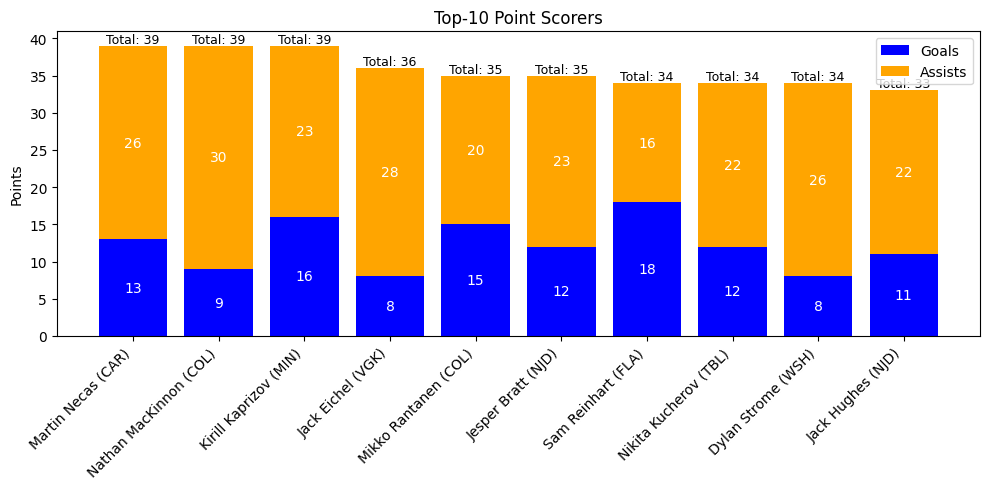

In [107]:
fig, ax = plt.subplots(figsize=(10,5))
bars_goals = ax.bar(players, goals, label='Goals', color='blue')
bars_assists = ax.bar(players, assists, label='Assists', bottom=goals, color='orange')

for bar_goal, bar_assist, goal, assist in zip(bars_goals, bars_assists, goals, assists):
    # Label for Goals
    ax.text(
        bar_goal.get_x() + bar_goal.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() / 2,                   # Midpoint of the bar
        str(goal),                                   # Goal value
        ha='center', va='center', color='white'
    )
    
    # Label for Assists
    ax.text(
        bar_assist.get_x() + bar_assist.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() + bar_assist.get_height() / 2,  # Midpoint of the top bar
        str(assist),                                     # Assist value
        ha='center', va='center', color='white'
    )

# Add total points label above the stacked bars
for i, total in enumerate(top10_point_scorers['points']):
    ax.text(
        i,                                               # x-coordinate (index of bar)
        goals.iloc[i] + assists.iloc[i],             # Slightly above the top bar
        f"Total: {total}",                               # Total points value
        ha='center', va='bottom', fontsize=9, color='black'
    )

ax.set_title('Top-10 Point Scorers')
ax.set_ylabel('Points')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Goalie Save Percentage against the League average 

In [108]:
df_goalies_performance.head()

,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,...,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry
0,2024020374,WPG,R,2024-11-29,0,0,1,L,30,4,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
1,2024020329,WPG,R,2024-11-23,0,0,1,L,35,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
2,2024020259,WPG,R,2024-11-14,0,0,1,L,28,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
3,2024020171,WPG,R,2024-11-01,0,0,1,W,22,2,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN
4,2024020129,WPG,R,2024-10-26,0,0,1,W,29,3,...,https://assets.nhle.com/mugs/nhl/20242025/WPG/...,Eric,Comrie,1,G,L,185,86,1995-07-06,CAN


In [109]:
top5_goalies_save_pct = df_goalies_performance.groupby(by=['id']).agg(
    shotsAgainst = ('shotsAgainst', 'sum'),
    goalsAgainst = ('goalsAgainst', 'sum'),
    gamesPlayed = ('gameId', 'count')
    ).reset_index()

In [110]:
top5_goalies_save_pct['savePct'] = 1 - top5_goalies_save_pct['goalsAgainst']/top5_goalies_save_pct['shotsAgainst']

In [111]:
min_games_played = (df_goalies_performance.groupby('teamAbbrev')['gameDate'].count().mean() * 0.35).round()

In [112]:
min_games_played

np.float64(9.0)

In [113]:
top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

,id,shotsAgainst,goalsAgainst,gamesPlayed,savePct
0,8479406,552,39,19,0.929348
1,8476945,586,43,20,0.926621
2,8476932,408,31,14,0.924020
3,8480843,520,41,15,0.921154
4,8481692,413,34,13,0.917676


In [114]:
top5_goalies_save_pct = top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

In [115]:
top5_goalies_save_pct_ids = top5_goalies_save_pct['id']

In [116]:
top5_goalies_save_pct_logs = df_goalies_performance[
    df_goalies_performance['id'].isin(top5_goalies_save_pct_ids)
    ][['id', 'gameDate','firstName', 'lastName', 'teamAbbrev', 'shotsAgainst', 'goalsAgainst']].sort_values(by=['id', 'gameDate'])

In [117]:
top5_goalies_save_pct_logs['id'].unique()

array([8476932, 8476945, 8479406, 8480843, 8481692])

In [118]:
top5_goalies_save_pct_logs['savePercent'] = 1 - top5_goalies_save_pct_logs['goalsAgainst'] / top5_goalies_save_pct_logs ['shotsAgainst']

In [119]:
top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

289    0.962963
288    0.938003
287    0.939061
286    0.935777
285    0.936857
         ...   
391    0.919670
390    0.948488
389    0.951361
388    0.945747
387    0.928401
Name: savePercent, Length: 81, dtype: float64

In [120]:
top5_goalies_save_pct_logs['rollingSavePercent'] = top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

In [121]:
top5_goalies_save_pct_logs['label'] = top5_goalies_save_pct_logs['firstName'] + ' ' + top5_goalies_save_pct_logs['lastName'] + ' (' + top5_goalies_save_pct_logs['teamAbbrev'] + ')'

In [122]:
top5_goalies_save_pct_logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 289 to 387
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  81 non-null     int64  
 1   gameDate            81 non-null     object 
 2   firstName           81 non-null     object 
 3   lastName            81 non-null     object 
 4   teamAbbrev          81 non-null     object 
 5   shotsAgainst        81 non-null     int64  
 6   goalsAgainst        81 non-null     int64  
 7   savePercent         81 non-null     float64
 8   rollingSavePercent  81 non-null     float64
 9   label               81 non-null     object 
dtypes: float64(2), int64(3), object(5)
memory usage: 7.0+ KB


In [123]:
top5_goalies_save_pct_logs = top5_goalies_save_pct_logs.astype({'gameDate': 'datetime64[s]'})

In [124]:
top5_goalies_save_pct_logs

,id,gameDate,firstName,lastName,teamAbbrev,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label
289,8476932,2024-10-09,Anthony,Stolarz,TOR,27,1,0.962963,0.962963,Anthony Stolarz (TOR)
288,8476932,2024-10-12,Anthony,Stolarz,TOR,23,2,0.913043,0.938003,Anthony Stolarz (TOR)
287,8476932,2024-10-16,Anthony,Stolarz,TOR,34,2,0.941176,0.939061,Anthony Stolarz (TOR)
286,8476932,2024-10-19,Anthony,Stolarz,TOR,27,2,0.925926,0.935777,Anthony Stolarz (TOR)
285,8476932,2024-10-21,Anthony,Stolarz,TOR,34,2,0.941176,0.936857,Anthony Stolarz (TOR)
...,...,...,...,...,...,...,...,...,...,...
391,8481692,2024-11-15,Dustin,Wolf,CGY,29,0,1.000000,0.919670,Dustin Wolf (CGY)
390,8481692,2024-11-19,Dustin,Wolf,CGY,29,1,0.965517,0.948488,Dustin Wolf (CGY)
389,8481692,2024-11-21,Dustin,Wolf,CGY,29,2,0.931034,0.951361,Dustin Wolf (CGY)
388,8481692,2024-11-25,Dustin,Wolf,CGY,30,4,0.866667,0.945747,Dustin Wolf (CGY)


In [125]:
all_dates = pd.date_range(start=top5_goalies_save_pct_logs['gameDate'].min(), end=top5_goalies_save_pct_logs['gameDate'].max())

In [126]:
aligned_data = []

for id, group in top5_goalies_save_pct_logs.groupby('id'):
    group = group.set_index('gameDate').reindex(all_dates)
    group['id'] = id
    group['rollingSavePercent'] = group['rollingSavePercent'].interpolate(limit_area='inside')
    aligned_data.append(group)

top5_goalies_save_pct_logs_aligned = pd.concat(aligned_data)

top5_goalies_save_pct_logs_aligned = top5_goalies_save_pct_logs_aligned.reset_index().rename(columns={'index':'gameDate'})

top5_goalies_save_pct_logs_aligned['label'] = (
    top5_goalies_save_pct_logs_aligned['label'].dropna()
)

In [127]:
top5_goalies_save_pct_logs_aligned.loc[top5_goalies_save_pct_logs_aligned['id'] == 8480843].head()

,gameDate,id,firstName,lastName,teamAbbrev,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label
168,2024-10-09,8480843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,2024-10-10,8480843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,2024-10-11,8480843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,2024-10-12,8480843,Lukas,Dostal,ANA,30.0,0.0,1.0,1.000000,Lukas Dostal (ANA)
172,2024-10-13,8480843,NaN,NaN,NaN,NaN,NaN,NaN,0.983333,NaN


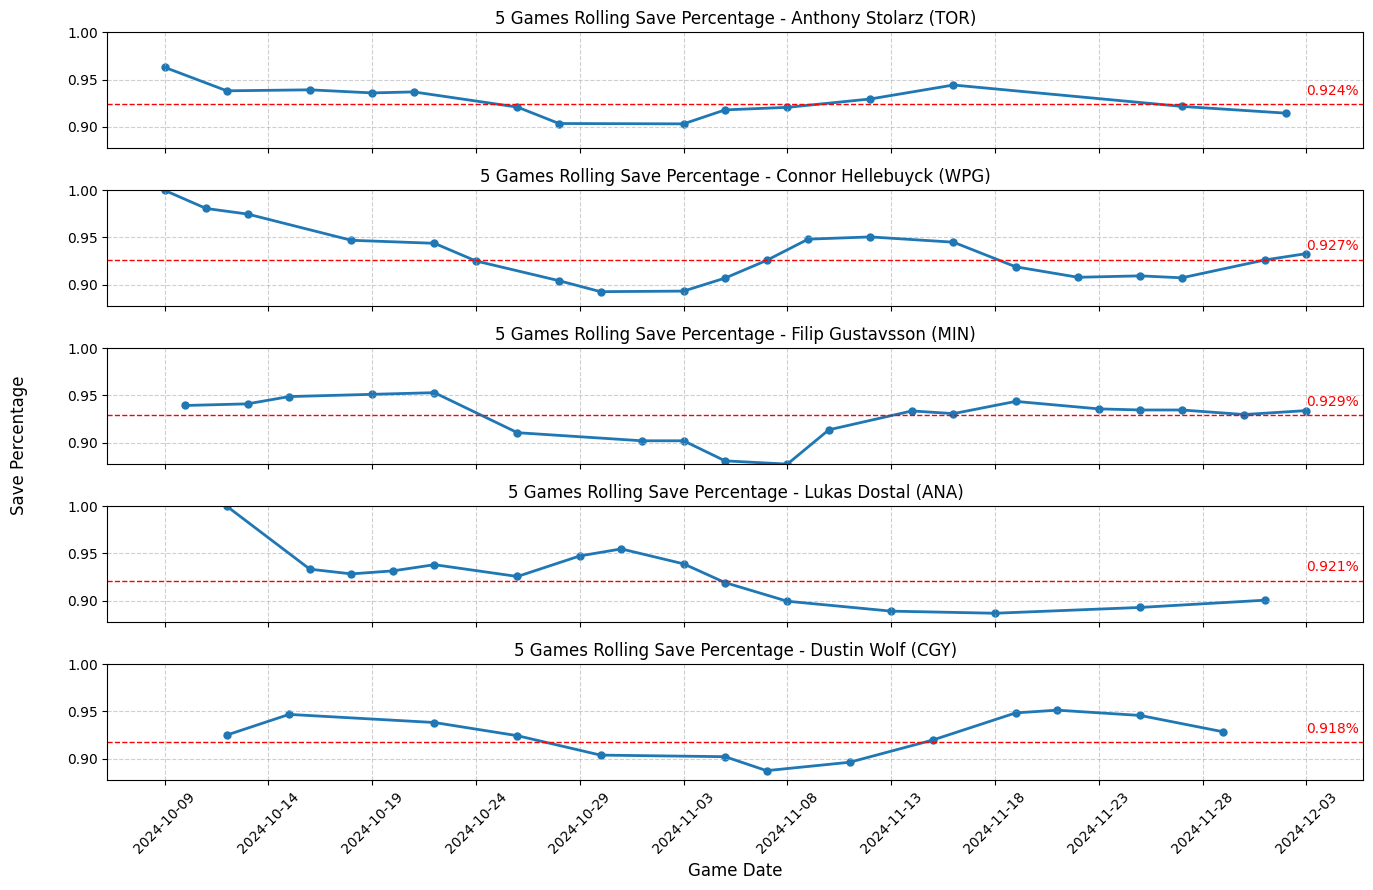

In [ ]:
# Determine global Y-axis limits
y_min = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].min()
y_max = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].max()

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), sharex=True)

# Iterate over subplots and goalie data
for ax, (id, group) in zip(axes, top5_goalies_save_pct_logs_aligned.groupby('id')):
    group_label = group['label'][group['label'].notnull()].unique()[0]
    avg_save_pct = 1- group['goalsAgainst'].sum() / group['shotsAgainst'].sum()

    # Line plot for rolling save percentage
    ax.plot(
        group['gameDate'], 
        group['rollingSavePercent'], 
        label=group_label,
        linewidth=2
    )
    
    # Scatter plot for save percentage points
    ax.scatter(
        group.loc[group['savePercent'].notna()]['gameDate'],
        group.loc[group['savePercent'].notna()]['rollingSavePercent'],
        marker='.',
        linewidths=3
    )

    ax.axhline(
        y=avg_save_pct,
        linewidth=1,
        linestyle='--',
        color='red',
        label=f'Avg. Save %'
    )

    ax.text(
        group['gameDate'].iloc[-1],  # Last game's date for placement
        avg_save_pct + 0.01,
        f"{avg_save_pct:.3f}%", 
        color='red', 
        fontsize=10, 
    )

    # Title, grid, and set uniform Y-axis limits
    ax.set_title(f"5 Games Rolling Save Percentage - {group_label}", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(y_min, y_max)  # Set consistent Y limits

# Global settings
axes[-1].set_xlabel('Game Date', fontsize=12)  # Add X-axis label only to the last subplot

# Global Y-axis label placed outside the chart area
fig.text(0.02, 0.5, 'Save Percentage', va='center', rotation='vertical', fontsize=12)

# Set uniform X ticks and format
xticks = top5_goalies_save_pct_logs_aligned['gameDate'].unique()  # Get unique X values
axes[-1].set_xticks(xticks[::5])  # Use every 5th tick for clarity
axes[-1].tick_params(axis='x', rotation=45)


# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Add padding for labels
plt.show()


## Load data in Google Cloud Storage

In [129]:
from google.cloud import storage

In [161]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="creds/creds.json"

In [162]:
client = storage.Client()

In [163]:
client.get_bucket('nhl-api-bucket')

<Bucket: nhl-api-bucket>